**Mounting Google Drive**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing the libraries**

In [18]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Setting path for training, testing, and validation directories**

In [19]:
base_dir = '/content/drive/MyDrive/dataset'
train_dir = '/content/drive/MyDrive/dataset/train'
train_covid_dir = '/content/drive/MyDrive/dataset/train/COVID'
train_noncovid_dir = '/content/drive/MyDrive/dataset/train/non-COVID'
test_dir = '/content/drive/MyDrive/dataset/test'
test_covid_dir = '/content/drive/MyDrive/dataset/test/COVID'
test_noncovid_dir = '/content/drive/MyDrive/dataset/test/non-COVID'
valid_dir = '/content/drive/MyDrive/dataset/validation'
valid_covid_dir = '/content/drive/MyDrive/dataset/validation/COVID'
valid_noncovid_dir = '/content/drive/MyDrive/dataset/validation/non-COVID'

In [20]:
num_covid_train = len(os.listdir(train_covid_dir))
num_noncovid_train = len(os.listdir(train_noncovid_dir))
num_covid_validation = len(os.listdir(valid_covid_dir))
num_noncovid_validation= len(os.listdir(valid_noncovid_dir))
num_covid_test = len(os.listdir(test_covid_dir))
num_noncovid_test= len(os.listdir(test_noncovid_dir))

In [21]:
print("Total Training Covid Images",num_covid_train)
print("Total Training Non-Covid Images",num_noncovid_train)
print("--")
print("Total validation Covid Images",num_covid_validation)
print("Total validation Non-Covid Images",num_noncovid_validation)
print("--")
print("Total Test Covid Images", num_covid_test)
print("Total Test Non-Covid Images",num_noncovid_test)
total_train = num_covid_train+num_noncovid_train
total_validation = num_covid_validation+num_noncovid_validation
total_test = num_covid_test+num_noncovid_test
print("Total Training Images",total_train)
print("--")
print("Total Validation Images",total_validation)
print("--")
print("Total Testing Images",total_test)

Total Training Covid Images 770
Total Training Non-Covid Images 759
--
Total validation Covid Images 247
Total validation Non-Covid Images 244
--
Total Test Covid Images 248
Total Test Non-Covid Images 245
Total Training Images 1529
--
Total Validation Images 491
--
Total Testing Images 493


**Defining Image Size and Batch Size for model training**

In [22]:
IMG_SHAPE  = 240
batch_size = 32

**Pre-processing on training, validation, and testing data**

In [23]:
image_gen_train = ImageDataGenerator(rescale = 1./255)
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
directory = train_dir,
shuffle= True,
target_size = (IMG_SHAPE,IMG_SHAPE),
class_mode = 'binary')
image_generator_validation = ImageDataGenerator(rescale=1./255)
val_data_gen = image_generator_validation.flow_from_directory(batch_size=batch_size,
directory=valid_dir,
target_size=(IMG_SHAPE, IMG_SHAPE),
class_mode='binary')
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
directory=test_dir,
target_size=(IMG_SHAPE, IMG_SHAPE),
class_mode='binary')

Found 1529 images belonging to 2 classes.
Found 491 images belonging to 2 classes.
Found 493 images belonging to 2 classes.


In [24]:
train_data_gen.class_indices

{'COVID': 0, 'non-COVID': 1}

**Setting model parameters**

In [25]:
covid_classifier = tf.keras.Sequential([
tf.keras.layers.Conv2D(16,(3,3),activation = tf.nn.relu,input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(32,(3,3),activation = tf.nn.relu),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64,(3,3),activation = tf.nn.relu),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(128,(3,3),activation = tf.nn.relu),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(512,kernel_regularizer = tf.keras.regularizers.l2(0.001), activation = tf.nn.relu),
tf.keras.layers.Dense(2,activation = tf.nn.sigmoid)
])

**Compiling Model Parameters**

In [26]:
covid_classifier.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

**Model Summary**

In [27]:
covid_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 119, 119, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 117, 117, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 64)      

**Training**

In [28]:
history_covid_classifier = covid_classifier.fit(train_data_gen, steps_per_epoch=(total_train//batch_size),
epochs = 50,
validation_data=val_data_gen,
validation_steps=(total_validation//batch_size),
batch_size = batch_size,
verbose = 1)

Epoch 1/50
47/47 [==============================] - 262s 6s/step - loss: 1.1034 - acc: 0.5357 - val_loss: 0.8136 - val_acc: 0.7104
Epoch 2/50
47/47 [==============================] - 102s 2s/step - loss: 0.7595 - acc: 0.6680 - val_loss: 0.6505 - val_acc: 0.6792
Epoch 3/50
47/47 [==============================] - 102s 2s/step - loss: 0.5755 - acc: 0.7629 - val_loss: 0.6101 - val_acc: 0.7333
Epoch 4/50
47/47 [==============================] - 103s 2s/step - loss: 0.4375 - acc: 0.8524 - val_loss: 0.5143 - val_acc: 0.7792
Epoch 5/50
47/47 [==============================] - 103s 2s/step - loss: 0.3218 - acc: 0.9025 - val_loss: 0.7025 - val_acc: 0.7188
Epoch 6/50
47/47 [==============================] - 104s 2s/step - loss: 0.2477 - acc: 0.9319 - val_loss: 0.6739 - val_acc: 0.7125
Epoch 7/50
47/47 [==============================] - 102s 2s/step - loss: 0.2305 - acc: 0.9392 - val_loss: 0.6391 - val_acc: 0.7000
Epoch 8/50
47/47 [==============================] - 102s 2s/step - loss: 0.2791 - a

**Testing the model**

In [37]:
results = covid_classifier.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy",results)

16/16 [==============================] - 11s 641ms/step - loss: 2.7223 - acc: 0.6653
test_loss, test accuracy [2.722296714782715, 0.6653143763542175]


**Importing few libraries**

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Checking history of model parameters**

In [45]:
history_dict = history_covid_classifier.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


**Visualizing Accuracy and Loss Results**

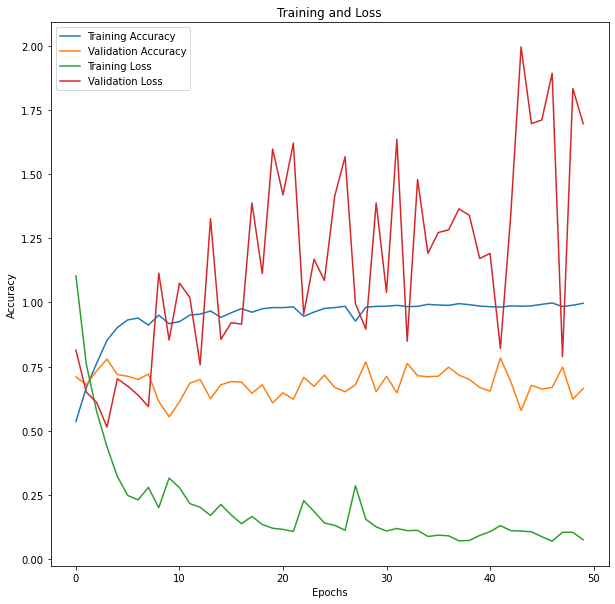

In [47]:
acc = history_covid_classifier.history['acc']
val_acc = history_covid_classifier.history['val_acc']

loss = history_covid_classifier.history['loss']
val_loss = history_covid_classifier.history['val_loss']

epochs_range = range(50)
plt.figure(figsize=(10, 10))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

**Saving the model**

In [48]:
model_json = covid_classifier.to_json()
with open("/content/drive/MyDrive/dataset/disease_detection.json", "w") as json_file:
    json_file.write(model_json)
covid_classifier.save("/content/drive/MyDrive/dataset/disease_detection.h5")
print("Saved model to disk")
covid_classifier.save_weights("/content/drive/MyDrive/dataset/SCC-Weights.h5")

Saved model to disk


**Importing few ibraries**

In [54]:
import time 
from sklearn.metrics import auc
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from skimage import transform
from keras.models import load_model
from keras.preprocessing import image

**Classification matrix of model**

In [50]:
prediction = covid_classifier.predict(test_data_gen)
pred_class = np.argmax(prediction, axis=1)

true_classes = test_data_gen.classes
class_labels = list(test_data_gen.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

       COVID       0.19      0.51      0.28        95
   non-COVID       0.81      0.50      0.62       398

    accuracy                           0.50       493
   macro avg       0.50      0.50      0.45       493
weighted avg       0.69      0.50      0.55       493



**Function to plot images**

In [51]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

**Prediction**

The below image is non-COVID i.e COVID negative


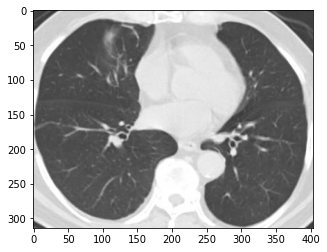

In [61]:
image_1 = cv2.imread('/content/drive/MyDrive/dataset/test/non-COVID/Non-Covid (750).png')
image = cv2.resize(image_1, (240, 240))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = covid_classifier.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
  res = "COVID positive"
elif classes==1:
  res = "non-COVID i.e COVID negative"
plt.imshow(image_1)
print("The below image is",res)

**Prediction**

The below image is COVID positive


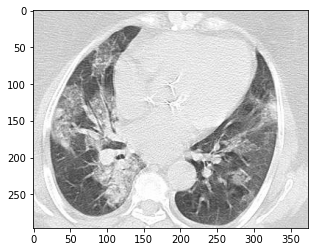

In [62]:
image_1 = cv2.imread('/content/drive/MyDrive/dataset/test/COVID/Covid (1004).png')
image = cv2.resize(image_1, (240, 240))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = covid_classifier.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
  res = "COVID positive"
elif classes==1:
  res = "non-COVID i.e COVID negative"
plt.imshow(image_1)
print("The below image is",res)